# Importing Dependencies

In [1]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

# Task B3
import plotly.graph_objects as go
import plotly.express as px

# Task B4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

C:\Users\THO NGUYEN\AppData\Local\Temp\ipykernel_2092\123073750.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Hyperparameters

In [2]:
# Task B2
TICKER = "AMZN"
START_DATE = "2014-01-01"
END_DATE = "2020-12-31"
LOOK_UP_DAYS = 30      
TRAINING_RATIO = 0.9    # 0.7 == 70%
SPLIT_BY_DATE = False
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

# Task B3
TRADING_PERIOD = 30
CONSECUTIVE_DAYS = 300

# Task B2: DATA PROCESSING 1

## Scaling dataset

In [3]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()
        
    
    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()

    
    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index
    
    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers


## Loading Data Function

In [4]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")
    
    if not os.path.isdir("data"):
        os.mkdir("data")


    
    # checking if the data is already downloaded 
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file 
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        print("Local Stock Data is enough for requirements, do not need to download")
    else: 
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        print("Local Stock Data is not enough for requirements, continuing downloading...")

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data
    
    return result

# Splitting Dataset

In [5]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS, 
        training_ratio=TRAINING_RATIO,  
        feature_columns=['Open','High','Low','Close','Adj Close','Volume']):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "X_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        }
    }
  
    for column in feature_columns:
        dataset_in_column = dataset[column].values.reshape(-1, 1)      # <class 'numpy.ndarray'>
        x_data = []
        y_data = []
    
        for x in range(look_up_days, len(dataset_in_column)):
            x_data.append(dataset_in_column[x - look_up_days:x, 0])
            y_data.append(dataset_in_column[x, 0])

        splitResult["X_training_set"][column], splitResult["X_testing_set"][column], splitResult["Y_training_set"][column], splitResult['Y_testing_set'][column] = train_test_split(x_data, y_data, test_size=1-training_ratio, shuffle=False)

        ## Converting to numpy.array

        for column in feature_columns:
            splitResult["X_training_set"][column] = np.array(splitResult["X_training_set"][column])
            splitResult["Y_training_set"][column] = np.array(splitResult["Y_training_set"][column])
            splitResult["X_testing_set"][column] = np.array(splitResult["X_testing_set"][column])
            splitResult["Y_testing_set"][column] = np.array(splitResult["Y_testing_set"][column])

    return splitResult

## Data Processing 1 (FULL)

A function to load and process a dataset with multiple features with the following requirements: 

+ Specify the start date and the end date for the whole 
dataset as inputs. 
+ Allowing you to deal with the NaN issue in the data
+ Splitting dataset according to some specified ratio of train/test
+ Storing the downloaded data on your local machine for future uses
+ Allowing you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

In [9]:
def Data_Processing_1():
    StockData = DataLoader()

    scaledStockData, datasetScaler, columnScalers = DataScaler(stock_data=StockData["dataset"])

    
    dataset = datasetSplitter(dataset=scaledStockData)
    
    print("Loaded Done!\nThe result is a tuple as below:\n")
    print("(dataset, scaledStockData, datasetScaler, columnScalers), where:\n")
    print("dataset is a dictionary as below:")
    print('''{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ...,
                        'Low': ...,
                        ...
                        }
    }\n''')
    print("scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)\n")
    print("datasetScaler is the Scaler of the dataset\n")
    print("columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature")

    return dataset, scaledStockData, datasetScaler, columnScalers
    

In [10]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Local Stock Data is not enough for requirements, continuing downloading...
Loaded Done!
The result is a tuple as below:

(dataset, scaledStockData, datasetScaler, columnScalers), where:

dataset is a dictionary as below:
{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ..

# Task B3: DATA PROCESSING 2

## Inverse Data

In [11]:
def datasetInverser(scaledStockData, datasetScaler):
    
    # Getting Column name
    col_names = scaledStockData.columns
    # Inversing the dataframe
    re_scaled_features = datasetScaler.inverse_transform(scaledStockData)
    re_scaled_stock_data = pd.DataFrame(re_scaled_features, columns = col_names)
    # Assigning index to the rescaled_data
    re_scaled_stock_data.index = scaledStockData.index


    ## A Pandas Dataframe
    return re_scaled_stock_data
       

## Candlestick Chart

In [12]:
def CandleStick(scaledStockData, datasetScaler, TradingPeriod=TRADING_PERIOD):
    
    # Loading the dataset
    scaled_stock_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        scaled_stock_data = datasetInverser(scaledStockData, datasetScaler)
    else:
        scaled_stock_data = scaledStockData


    # Processed Data to fit the Trading Period
    total_records = len(scaled_stock_data)
    Price_Data = {  'Date': [],
                    'Open': [],
                    'High': [],
                    'Low': [],
                    'Close': [],
                    'Volume': []
                }
    
    
    ## Loop through the DataFrame in batches of TradingPeriod
    for i in range(0, total_records, TradingPeriod):
        batch = scaled_stock_data.iloc[i:i+TradingPeriod]

        Price_Data['Date'].append(batch.index[0])
        Price_Data['Open'].append(batch['Open'].values[0])   
        Price_Data['High'].append(max(batch['High'].values))
        Price_Data['Low'].append(min(batch['Low'].values))
        Price_Data['Close'].append(batch['Close'].values[len(batch) - 1])
        Price_Data['Volume'].append(sum(batch['Volume'].values))

    
    # Converting to Pandas Dataframe
    NewDataFrame = pd.DataFrame(Price_Data)
    NewDataFrame.set_index('Date', inplace=True)


    fig = go.Figure(data=[go.Candlestick(x=NewDataFrame.index,                         
                open=NewDataFrame['Open'],
                high=NewDataFrame['High'],
                low=NewDataFrame['Low'],
                close=NewDataFrame['Close'])])

    fig.update_layout(
        title=f"Candle Stick Chart for {TICKER} shared price, Trading Period = {TRADING_PERIOD} day(s)",
        xaxis_title="Time",
        yaxis_title="Shared Price (USD)"
    )
    fig.show()


## Boxplot Chart

In [14]:
def BoxPlot(scaledStockData, datasetScaler, ConsecutiveDays=CONSECUTIVE_DAYS, features=['Open', 'High', 'Low', 'Close']):
    # Loading the dataset
    scaled_stock_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        scaled_stock_data = datasetInverser(scaledStockData, datasetScaler)
    else:
        scaled_stock_data = scaledStockData

    total_records = len(scaled_stock_data)

    consecutive_days_array = []
    ## Loop through the DataFrame in batches of ConsecutiveDays
    for i in range(0, total_records, ConsecutiveDays):
        batch = scaled_stock_data.iloc[i:i+ConsecutiveDays]
        StartDate = batch.index[0].strftime('%Y-%m-%d')
        EndDate = batch.index[len(batch) - 1].strftime('%Y-%m-%d')
        
        consecutive_period = f"{StartDate} to {EndDate}"
        for _ in range(len(batch)):
            consecutive_days_array.append(consecutive_period)
        
    scaled_stock_data['Consecutive'] = consecutive_days_array
    scaled_stock_data['Consecutive'] = scaled_stock_data['Consecutive'].astype("string")
    

    for feature in features:
        fig = px.box(scaled_stock_data, x="Consecutive", y="Open")

        fig.update_layout(
        title=f"Boxplot Chart for {TICKER} shared price, Consecutive Days = {CONSECUTIVE_DAYS} day(s)",
        xaxis_title="Time",
        yaxis_title=f"{feature} Price (USD)"
        )
        fig.show()

## Task B3: Data Processing 2 (Full)

In [15]:
def Data_Processing_2():
    CandleStick(scaledStockData, datasetScaler)

    BoxPlot(scaledStockData, datasetScaler)

In [16]:
Data_Processing_2()

# Task B4: Machine Learning 1

## Inversing A Column in the Dataset

In [14]:
def columnInverser(columnData, ColumnScaler):
    result = ColumnScaler.inverse_transform(columnData)
    return result

In [15]:
dataLoader = Load_Dataset()
StockData = dataLoader["dataset"]
columnScaler = dataLoader["column_scalers"]
stockDataOriginal = Inverse_Dataset()

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed

Local Stock Data is not enough for requirements, continuing downloading...
Local Stock Data is not enough for requirements, continuing downloading...


In [16]:
stockDataOriginal.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.940001,19.968000,19.701000,19.898500,19.898500,42756000.0
2014-01-03,19.914499,20.135500,19.811001,19.822001,19.822001,44204000.0
2014-01-06,19.792500,19.850000,19.421000,19.681499,19.681499,63412000.0
2014-01-07,19.752001,19.923500,19.714500,19.901501,19.901501,38320000.0
2014-01-08,19.923500,20.150000,19.802000,20.096001,20.096001,46330000.0
2014-01-09,20.185499,20.344500,19.922001,20.050501,20.050501,42060000.0
2014-01-10,20.126499,20.188000,19.690001,19.882999,19.882999,53590000.0
2014-01-13,19.899000,19.989000,19.422501,19.549000,19.549000,56898000.0
2014-01-14,19.606501,19.931499,19.564501,19.877001,19.877001,46802000.0


In [17]:
StockData.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.035064,0.033398,0.034352,0.034218,0.034218,0.054690
2014-01-03,0.034908,0.034425,0.035039,0.033746,0.033746,0.057842
2014-01-06,0.034160,0.032675,0.032604,0.032880,0.032880,0.099644
2014-01-07,0.033912,0.033126,0.034437,0.034236,0.034236,0.045036
2014-01-08,0.034963,0.034514,0.034983,0.035435,0.035435,0.062468
2014-01-09,0.036569,0.035707,0.035732,0.035155,0.035155,0.053176
2014-01-10,0.036207,0.034747,0.034284,0.034122,0.034122,0.078268
2014-01-13,0.034813,0.033527,0.032613,0.032063,0.032063,0.085468
2014-01-14,0.033020,0.033175,0.033500,0.034085,0.034085,0.063496


In [18]:
OpenOrignal = reverse_column(columnScaler["Open"], StockData["Open"].values.reshape(-1, 1))
print(OpenOrignal)

[[ 19.94000053]
 [ 19.91449928]
 [ 19.79249954]
 ...
 [159.69999695]
 [165.49699402]
 [167.05000305]]


In [19]:
x_open_train = np.reshape(splitResult["X_training_set"]["Open"], (splitResult["X_training_set"]["Open"].shape[0], splitResult["X_training_set"]["Open"].shape[1], 1))

In [25]:
# y_train = splitResult["Y_training_set"]["Open"]
# y_train_original = reverse_column(columnScaler["Open"], y_train.reshape(-1, 1))
# y_train_original = y_train_original.reshape(-1)

# print(y_train_original.shape)

(1385,)


In [44]:
y_open_train = splitResult["Y_training_set"]["Open"]
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_open_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['mean_squared_error'])
history = model.fit(x_open_train, y_open_train, epochs=25, batch_size=32)



Epoch 1/25


44/44 [==============================] - 6s 25ms/step - loss: 0.5112 - mean_squared_error: 0.0094
Epoch 2/25
44/44 [==============================] - 1s 29ms/step - loss: 0.4199 - mean_squared_error: 0.0020
Epoch 3/25
44/44 [==============================] - 1s 31ms/step - loss: 0.4170 - mean_squared_error: 0.0015
Epoch 4/25
44/44 [==============================] - 1s 32ms/step - loss: 0.4145 - mean_squared_error: 0.0012
Epoch 5/25
44/44 [==============================] - 1s 30ms/step - loss: 0.4162 - mean_squared_error: 0.0014
Epoch 6/25
44/44 [==============================] - 2s 36ms/step - loss: 0.4149 - mean_squared_error: 0.0012
Epoch 7/25
44/44 [==============================] - 1s 30ms/step - loss: 0.4243 - mean_squared_error: 0.0032
Epoch 8/25
44/44 [==============================] - 1s 29ms/step - loss: 0.4179 - mean_squared_error: 0.0018
Epoch 9/25
44/44 [==============================] - 1s 32ms/step - loss: 0.4148 - mean_squared_error: 0.0011
Epoch 10/25
44/

In [45]:
x_open_test = np.reshape(splitResult["X_testing_set"]["Open"], (splitResult["X_testing_set"]["Open"].shape[0], splitResult["X_testing_set"]["Open"].shape[1], 1))
predicted_prices = model.predict(x_open_test)

predicted_prices = reverse_column(columnScaler["Open"], predicted_prices.reshape(-1,1))
actual_prices = reverse_column(columnScaler["Open"], splitResult["Y_testing_set"]["Open"].reshape(-1, 1))
print(actual_prices)

11/11 [==============================] - 1s 8ms/step
[[ 89.64450073]
 [ 90.90399933]
 [ 90.72499847]
 [ 90.96949768]
 [ 91.40000153]
 [ 89.65149689]
 [ 88.34549713]
 [ 88.78649902]
 [ 87.75      ]
 [ 89.15000153]
 [ 89.87449646]
 [ 88.5       ]
 [ 90.25      ]
 [ 91.09750366]
 [ 91.91100311]
 [ 92.05000305]
 [ 91.13749695]
 [ 90.60700226]
 [ 91.88150024]
 [ 92.10050201]
 [ 91.2009964 ]
 [ 90.35399628]
 [ 90.85199738]
 [ 91.0510025 ]
 [ 91.08550262]
 [ 88.84999847]
 [ 89.53050232]
 [ 87.36799622]
 [ 88.13950348]
 [ 87.40000153]
 [ 86.34950256]
 [ 87.30000305]
 [ 86.38700104]
 [ 85.65000153]
 [ 86.3010025 ]
 [ 86.58149719]
 [ 86.12449646]
 [ 85.98049927]
 [ 86.26200104]
 [ 87.14600372]
 [ 86.44550323]
 [ 87.10700226]
 [ 88.66649628]
 [ 89.82450104]
 [ 89.38999939]
 [ 88.48300171]
 [ 89.40750122]
 [ 88.06500244]
 [ 88.55449677]
 [ 84.87750244]
 [ 87.40299988]
 [ 88.7405014 ]
 [ 88.01200104]
 [ 88.79949951]
 [ 89.40049744]
 [ 90.05049896]
 [ 90.45800018]
 [ 90.05000305]
 [ 90.18800354]
 [ 

In [47]:
import matplotlib.pyplot as plt

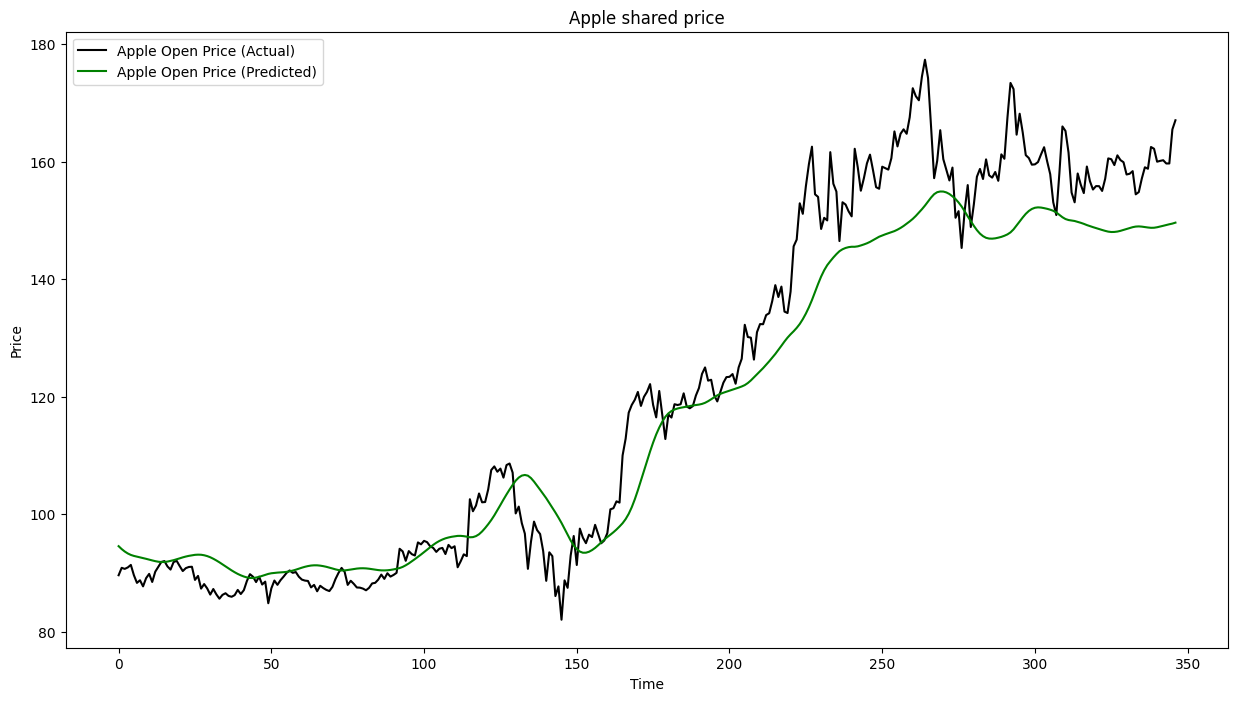

In [48]:
plt.figure(figsize=(15, 8)) 
plt.plot(actual_prices, c="black", label = "Apple Open Price (Actual)")
plt.plot(predicted_prices, c="green", label = "Apple Open Price (Predicted)")
plt.legend()
plt.title("Apple shared price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()